In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_vorticity(ERA5: xr.Dataset) -> xr.DataArray:
    earth_radius = 6371000  # [m], globally averaged

    ERA5_wrapped = (
        ERA5.pad(longitude=1, mode="wrap").pad(
            latitude=1, mode="reflect", reflect_type="even"
        )
    ).assign_coords(
        longitude=ERA5.longitude.pad(longitude=1, mode="reflect", reflect_type="odd"),
        latitude=ERA5.latitude.pad(latitude=1, mode="reflect", reflect_type="odd"),
    )

    ERA5_dUdTheta = (
        ERA5_wrapped["u"]
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ).differentiate("latitude")
    ERA5_dVdPhi = ERA5_wrapped["v"].differentiate("longitude")

    ERA5_VOR = (
        earth_radius
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ) ** (-1) * (ERA5_dVdPhi - ERA5_dUdTheta)

    ERA5_VOR = ERA5_VOR.sel(longitude=slice(0, 359.9), latitude=slice(89.9, -89.9))
    ERA5_VOR.attrs.update(long_name="vorticity", units="s**-1")

    return ERA5_VOR

In [5]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    ticks=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = (
        earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=10,
        )
        if ticks is None
        else ticks
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

In [6]:
ERA5_VOR = compute_vorticity(ERA5)

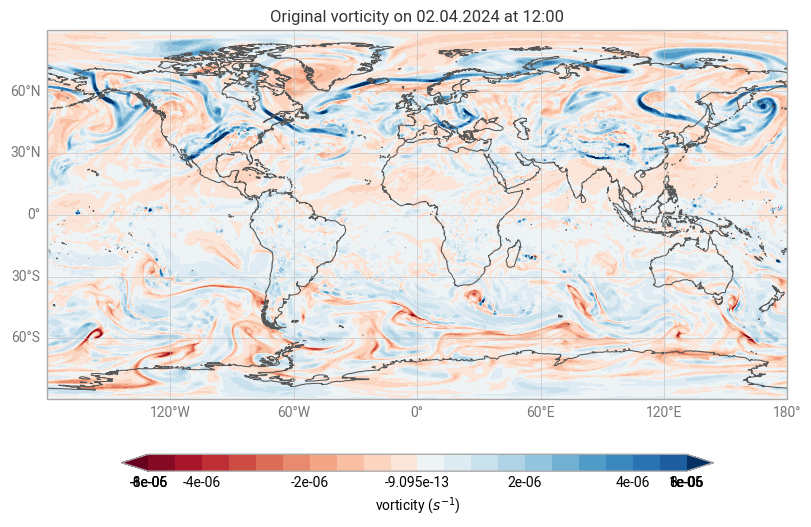

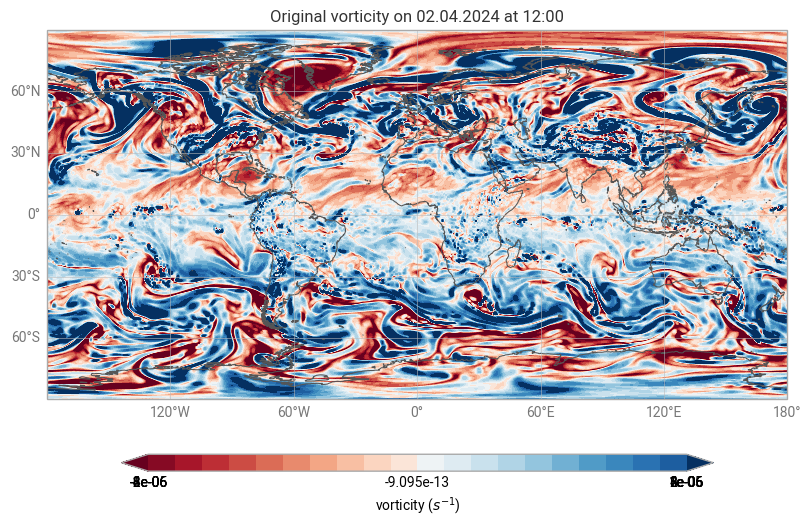

In [7]:
plot_data(
    ERA5_VOR,
    levels=np.arange(-5.0, 5.01, 0.5) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="Original ",
)
plot_data(
    ERA5_VOR,
    levels=np.arange(-1.0, 1.01, 0.1) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="Original ",
)

In [8]:
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

In [9]:
from numcodecs_wasm_zfp import Zfp

In [10]:
zfp = Zfp(mode="fixed-accuracy", tolerance=1)

In [11]:
ERA5_UV_zfp = zfp.decode(zfp.encode(ERA5_UV))
ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))

In [12]:
np.amax(np.abs(ERA5_UV_zfp - ERA5_UV))

np.float32(0.24009705)

In [13]:
ERA5_VOR_zfp = compute_vorticity(ERA5_zfp)

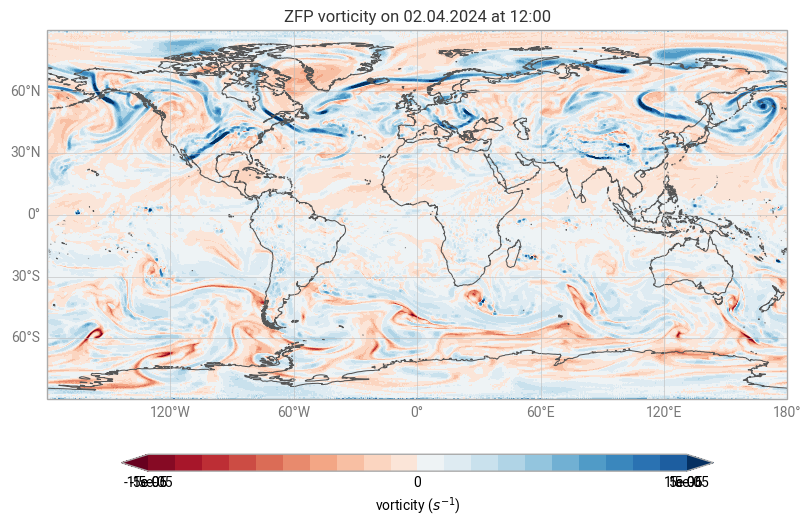

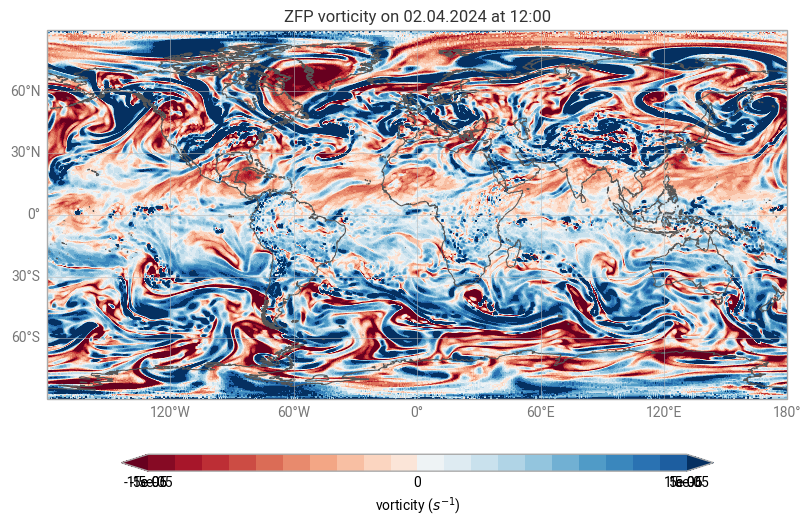

In [14]:
plot_data(
    ERA5_VOR_zfp,
    levels=np.arange(-5.0, 5.01, 0.5) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="ZFP ",
)
plot_data(
    ERA5_VOR_zfp,
    levels=np.arange(-1.0, 1.01, 0.1) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="ZFP ",
)

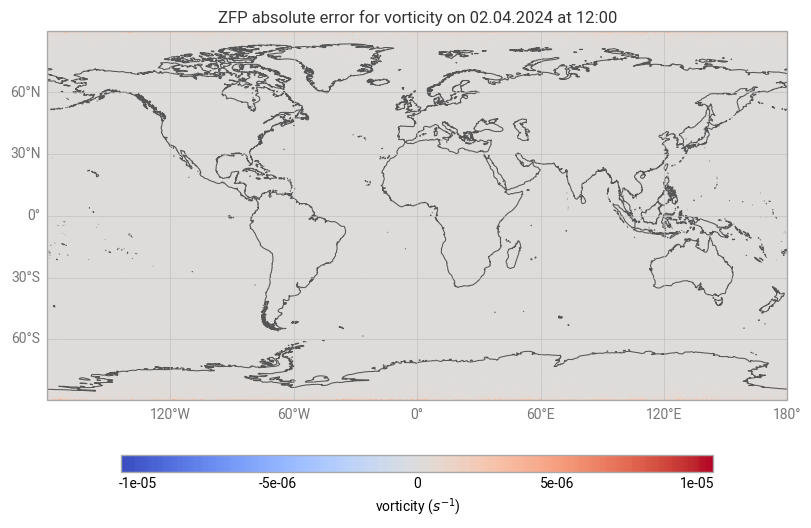

In [15]:
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_VOR_zfp - ERA5_VOR, error=True, title_prefix="ZFP absolute error for "
    )

In [16]:
from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [17]:
prediction = np.zeros_like(ERA5_UV)

In [18]:
sg = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="""
            let(
                V["earth_radius"], 6371000,  # [m], globally averaged
            )
            
            (let(
                # extract u and v from the last stacked dimension
                V["u"], X[I[0], I[1], 0],
                V["v"], X[I[0], I[1], 1],
                # convert latitude in degrees to radians
                V["latRad"], c["lat"] * pi / 180,
            )

            (let(
                # approximate the spatial derivatives with finite differences
                V["dUdTheta"], finite_difference(V["u"] * cos(V["latRad"]), order=1, accuracy=2, type=0, axis=0, grid_centre=c["lat"]),
                V["dVdPhi"], finite_difference(V["v"], order=1, accuracy=2, type=0, axis=1, grid_centre=c["lon"], grid_period=360),
            )
            
            (
                # compute the vorticity
                (V["earth_radius"] * cos(V["latRad"])) ** (-1) * (V["dVdPhi"] - V["dUdTheta"])
            )))
            """,
            type="rel",
            eb=0.01,
            neighbourhood=[
                # latitude
                dict(axis=0, before=1, after=1, boundary="reflect"),
                # longitude
                dict(axis=1, before=1, after=1, boundary="wrap"),
                # [u, v]
                dict(axis=-1, before=0, after=1, boundary="valid"),
            ],
        )
    ],
)

In [19]:
sg.safeguards[0]._qoi_expr

((-(Mod(c["lon"][1, 0, 0] - c["lon"][1, 1, 0] + 180, 360) - 180)/(Mod(-c["lon"][1, 1, 0] + c["lon"][1, 2, 0] + 180, 360) - 180) - 1)*X[1, 1, 1]/(Mod(c["lon"][1, 0, 0] - c["lon"][1, 1, 0] + 180, 360) - 180) - (-(c["lat"][0, 1, 0] - c["lat"][1, 1, 0])/(-c["lat"][1, 1, 0] + c["lat"][2, 1, 0]) - 1)*cos(pi*c["lat"][1, 1, 0]/180)*X[1, 1, 0]/(c["lat"][0, 1, 0] - c["lat"][1, 1, 0]) + (Mod(c["lon"][1, 0, 0] - c["lon"][1, 1, 0] + 180, 360) - 180)*X[1, 2, 1]/((Mod(c["lon"][1, 0, 0] - c["lon"][1, 2, 0] + 180, 360) - 180)*(Mod(-c["lon"][1, 1, 0] + c["lon"][1, 2, 0] + 180, 360) - 180)) - (c["lat"][0, 1, 0] - c["lat"][1, 1, 0])*cos(pi*c["lat"][2, 1, 0]/180)*X[2, 1, 0]/((c["lat"][0, 1, 0] - c["lat"][2, 1, 0])*(-c["lat"][1, 1, 0] + c["lat"][2, 1, 0])) + (-c["lat"][1, 1, 0] + c["lat"][2, 1, 0])*cos(pi*c["lat"][0, 1, 0]/180)*X[0, 1, 0]/((c["lat"][0, 1, 0] - c["lat"][1, 1, 0])*(c["lat"][0, 1, 0] - c["lat"][2, 1, 0])) - (Mod(-c["lon"][1, 1, 0] + c["lon"][1, 2, 0] + 180, 360) - 180)*X[1, 0, 1]/((Mod(c["lon"

In [20]:
correction_sg = sg.compute_correction(
    ERA5_UV,
    prediction,
    late_bound=Bindings(
        lat=ERA5.latitude.values.reshape(-1, 1, 1),
        lon=ERA5.longitude.values.reshape(1, -1, 1),
    ),
)

ERA5_UV_sg = sg.apply_correction(prediction, correction_sg)
ERA5_sg = ERA5.copy(data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1]))

In [21]:
np.amax(np.abs(ERA5_UV_sg - ERA5_UV))

np.float32(0.03501892)

In [22]:
ERA5_VOR_sg = compute_vorticity(ERA5_sg)

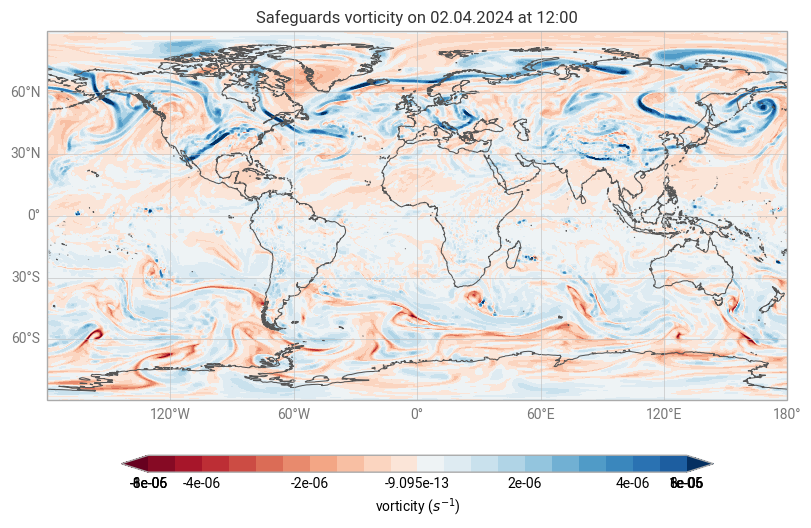

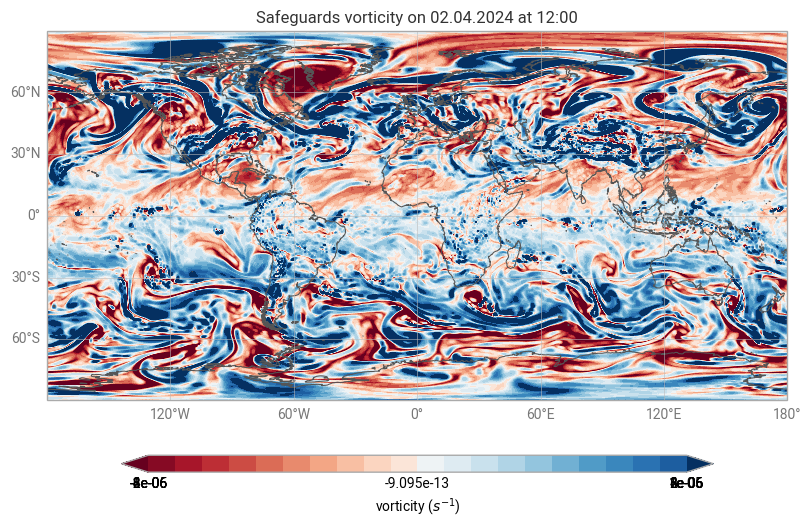

In [23]:
plot_data(
    ERA5_VOR_sg,
    levels=np.arange(-5.0, 5.01, 0.5) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="Safeguards ",
)
plot_data(
    ERA5_VOR_sg,
    levels=np.arange(-1.0, 1.01, 0.1) * 1e-6,
    cmap="RdBu",
    extend="both",
    title_prefix="Safeguards ",
)

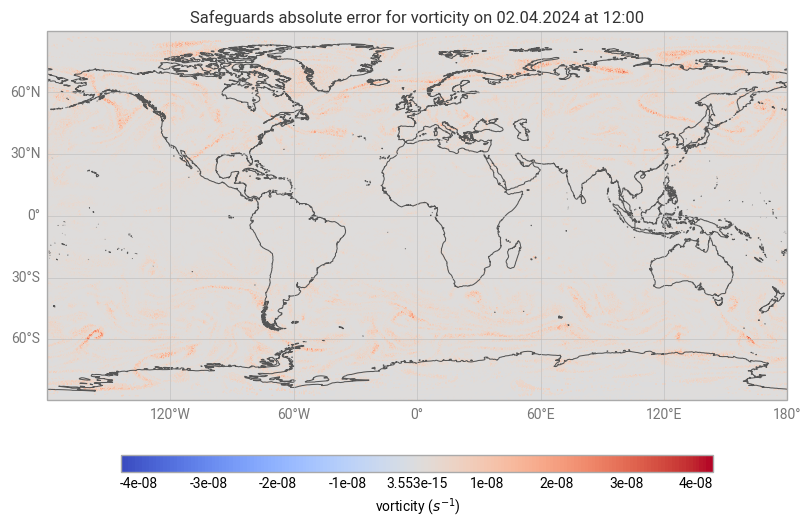

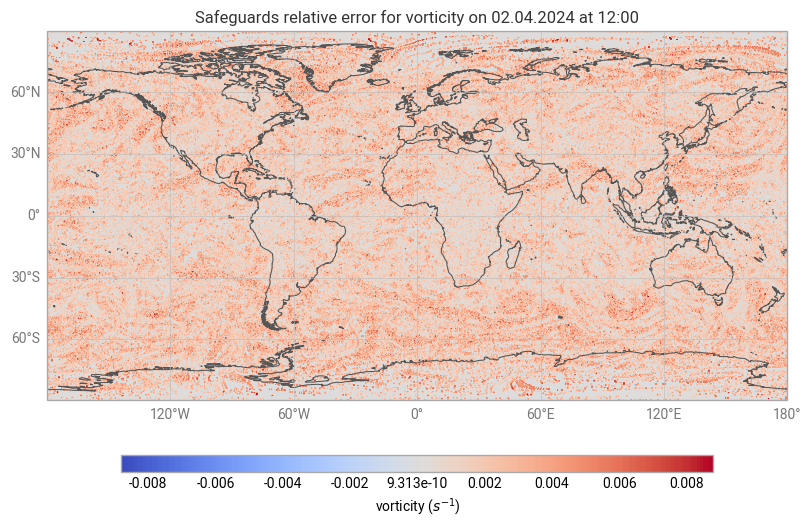

In [24]:
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_VOR_sg - ERA5_VOR,
        error=True,
        title_prefix="Safeguards absolute error for ",
    )
with xr.set_options(keep_attrs=True):
    plot_data(
        (ERA5_VOR_sg - ERA5_VOR) / np.abs(ERA5_VOR),
        error=True,
        title_prefix="Safeguards relative error for ",
    )